In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mini project/PH,NO2,SO2.csv')
df

,date,PH,NO2,SO2
0,2010-01-01,4.50,0.032,0.007750
1,2010-02-01,4.78,0.028,0.006000
2,2010-03-01,5.34,0.024,0.004750
3,2010-04-01,5.23,0.026,0.005125
4,2010-05-01,4.82,0.024,0.005500
...,...,...,...,...
127,2020-08-01,5.04,0.011,0.003000
128,2020-09-01,5.68,0.013,0.002750
129,2020-10-01,6.17,0.019,0.002875
130,2020-11-01,5.12,0.023,0.003000


In [ ]:
from tensorflow import keras

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i) # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
TRAIN_SPLIT = 100

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [ ]:
#특성들 목록에 추가

features = df[['NO2','PH','SO2']]
features.index = df['date']
features.head()

,NO2,PH,SO2
date,,,
2010-01-01,0.032,4.50,0.007750
2010-02-01,0.028,4.78,0.006000
2010-03-01,0.024,5.34,0.004750
2010-04-01,0.026,5.23,0.005125
2010-05-01,0.024,4.82,0.005500


In [ ]:
#dataset 표준화
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
#single step model
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 20
future_target = 5
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (20, 3)


In [ ]:
BATCH_SIZE = 100
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
#샘플예측 확인
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(7, 1)


In [ ]:
EVALUATION_INTERVAL = 121
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
121/121 [==============================] - 3s 12ms/step - loss: 0.9074 - val_loss: 0.7073
Epoch 2/10
121/121 [==============================] - 1s 9ms/step - loss: 0.3505 - val_loss: 0.6205
Epoch 3/10
121/121 [==============================] - 1s 9ms/step - loss: 0.3490 - val_loss: 0.6152
Epoch 4/10
121/121 [==============================] - 1s 9ms/step - loss: 0.3470 - val_loss: 0.6121
Epoch 5/10
121/121 [==============================] - 1s 9ms/step - loss: 0.3424 - val_loss: 0.5782
Epoch 6/10
121/121 [==============================] - 1s 10ms/step - loss: 0.3363 - val_loss: 0.5827
Epoch 7/10
121/121 [==============================] - 1s 9ms/step - loss: 0.3305 - val_loss: 0.5515
Epoch 8/10
121/121 [==============================] - 1s 9ms/step - loss: 0.3248 - val_loss: 0.5489
Epoch 9/10
121/121 [==============================] - 1s 9ms/step - loss: 0.3183 - val_loss: 0.5577
Epoch 10/10
121/121 [==============================] - 1s 10ms/step - loss: 0.3106 - val_loss: 0.5

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

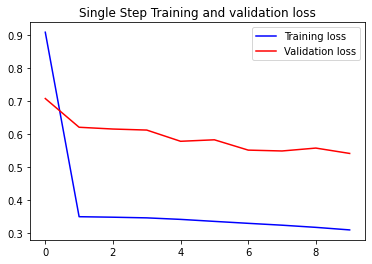

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

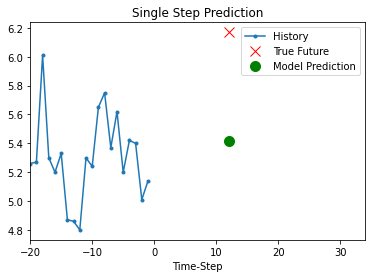

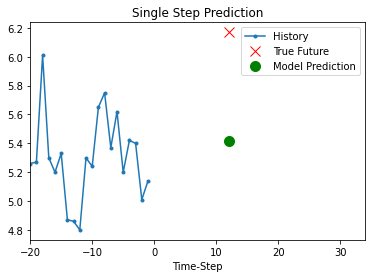

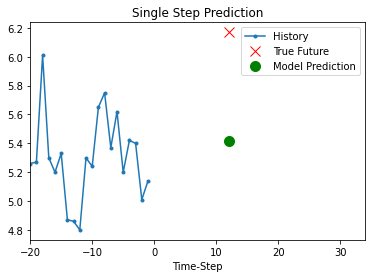

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Single window of past history : (20, 3)

 Target temperature to predict : (10,)


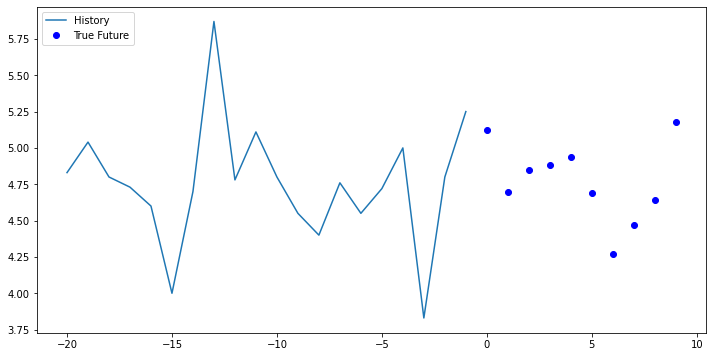

(2, 10)
Epoch 1/10000
121/121 [==============================] - 8s 41ms/step - loss: 0.8066 - val_loss: 0.9052
Epoch 2/10000
121/121 [==============================] - 6s 50ms/step - loss: 0.4579 - val_loss: 0.5453
Epoch 3/10000
121/121 [==============================] - 4s 37ms/step - loss: 0.4159 - val_loss: 0.9069
Epoch 4/10000
121/121 [==============================] - 4s 36ms/step - loss: 0.3961 - val_loss: 0.8843
Epoch 5/10000
121/121 [==============================] - 4s 36ms/step - loss: 0.3869 - val_loss: 0.8419
Epoch 6/10000
121/121 [==============================] - 4s 36ms/step - loss: 0.3740 - val_loss: 0.6688
Epoch 7/10000
121/121 [==============================] - 5s 38ms/step - loss: 0.3679 - val_loss: 0.7041
Epoch 8/10000
121/121 [==============================] - 5s 39ms/step - loss: 0.3558 - val_loss: 0.7720
Epoch 9/10000
121/121 [==============================] - 5s 40ms/step - loss: 0.3437 - val_loss: 0.8268
Epoch 10/10000
121/121 [==============================] 

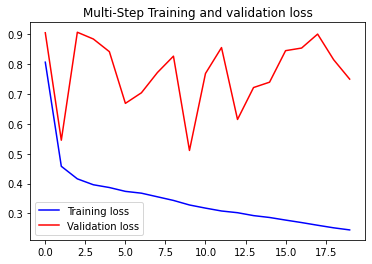

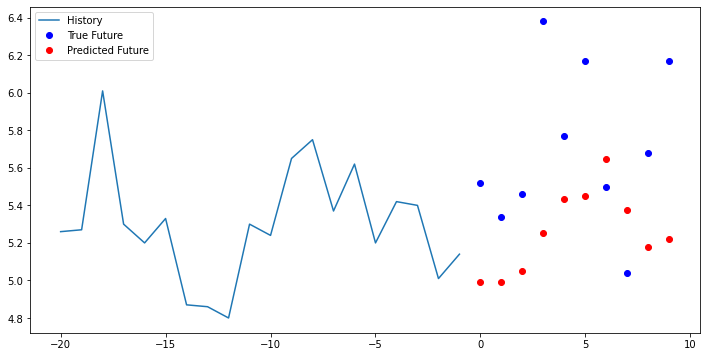

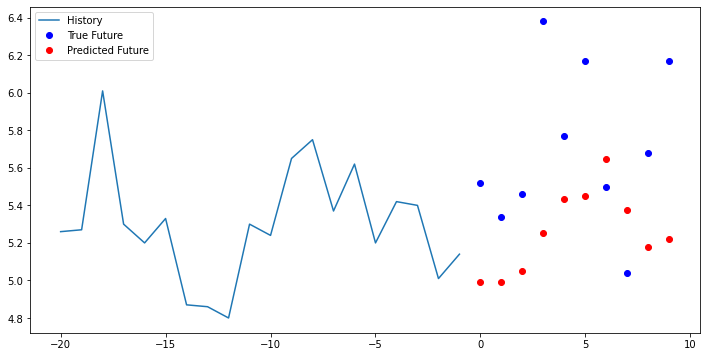

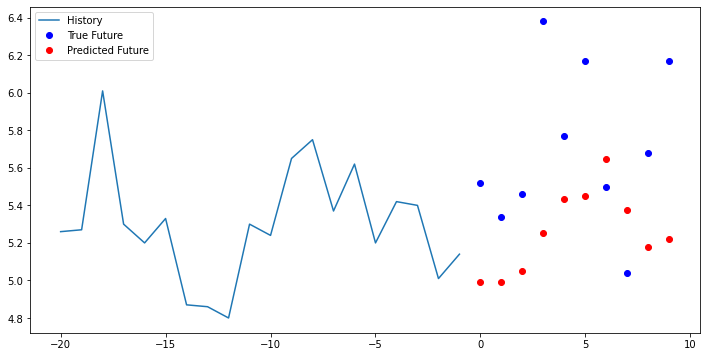

In [ ]:
future_target = 10
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()
#샘플 데이터 플로팅
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(100,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(35, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(10))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

EPOCHS = 10000
checkpoint_cb = keras.callbacks.ModelCheckpoint('bsm.h5',save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,callbacks=[checkpoint_cb,early_stopping_cb])
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])